<a href="https://colab.research.google.com/github/yanezdavid/Predicting-Home-Prices/blob/main/Predicting_Home_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Investigative Question:** Can we predict the value of houses in Boston?

# Load Data

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#import libraries
import pandas as pd
import numpy as np

#load & preview data
df = pd.read_csv('/content/drive/MyDrive/Data Science/Data/boston 3.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Explore & Clean Data

**Data Dictionary** from [Kaggle](https://www.kaggle.com/c/2403-boston-housing-dataset/overview):
* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per $10,000

* PTRATIO: pupil-teacher ratio by town
* B: the proportion of black people by town
* LSTAT: % lower status of the population
* **MEDV: Median value of owner-occupied homes in $1000's [Target Feature]**




In [ ]:
#check the dimensions of the data
df.shape

(506, 14)

In [ ]:
#confirm that the data types are numerical for machine learning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [ ]:
#check for missing values
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [ ]:
#confirm that there are no unwarranted duplicates
df.duplicated().sum()

0

In [ ]:
#check for misinputs and confirm that the categorical data is properly encoded
df['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

In [ ]:
df['RAD'].value_counts()

24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: RAD, dtype: int64

# EDA: Exploratory Data Analysis

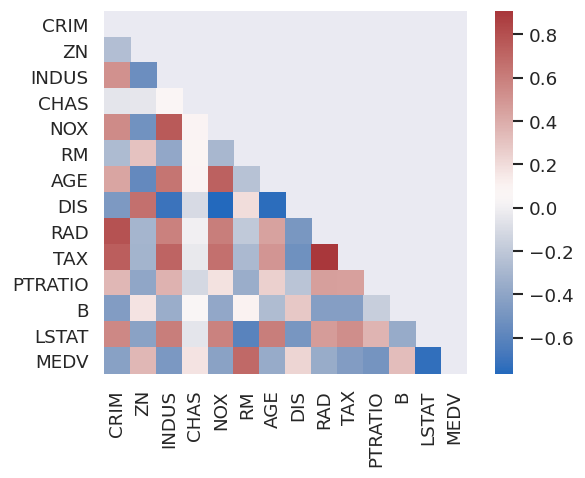

In [ ]:
#import libraries
import seaborn as sns
import matplotlib.pyplot as plt

#visualize relationships between features
plt.rcParams['figure.dpi'] = 120
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            cmap='vlag',
            mask=mask,
            square=True);

**Linear Regression should be avoided since there are strong relationships between features, otherwise known as multicollinearity. Multicollinearity will alter algorithms such as Linear Regression that assume linearity.**

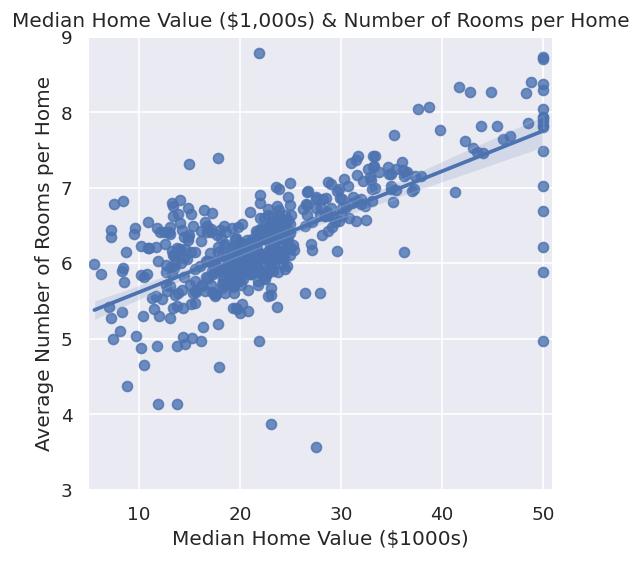

In [ ]:
#visualize the relationship between home value and number of rooms
plt.figure(figsize=(5, 5));
sns.set(style="darkgrid");
sns.regplot(x=df['MEDV'],
            y=df['RM']);
plt.title('Median Home Value ($1,000s) & Number of Rooms per Home')
plt.xlim(5,51);
plt.xlabel('Median Home Value ($1000s)');
plt.ylim(3,9);
plt.ylabel('Average Number of Rooms per Home');

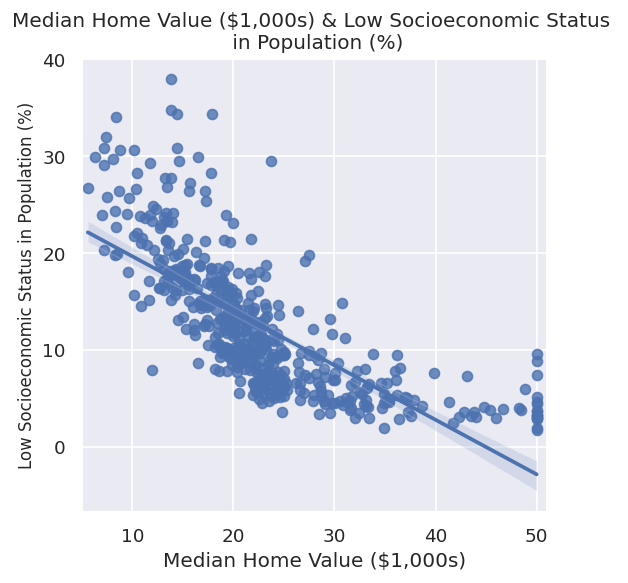

In [ ]:
#visualize the relationship between home value and % of low Socioeconomic Status folks in the population
plt.figure(figsize=(5, 5));
sns.regplot(x=df['MEDV'],
            y=df['LSTAT']);
plt.title('Median Home Value ($1,000s) & Low Socioeconomic Status \n in Population (%)')
plt.xlabel('Median Home Value ($1,000s)', fontsize=12);
plt.xlim(5,51)
plt.ylabel('Low Socioeconomic Status in Population (%)', fontsize=10);

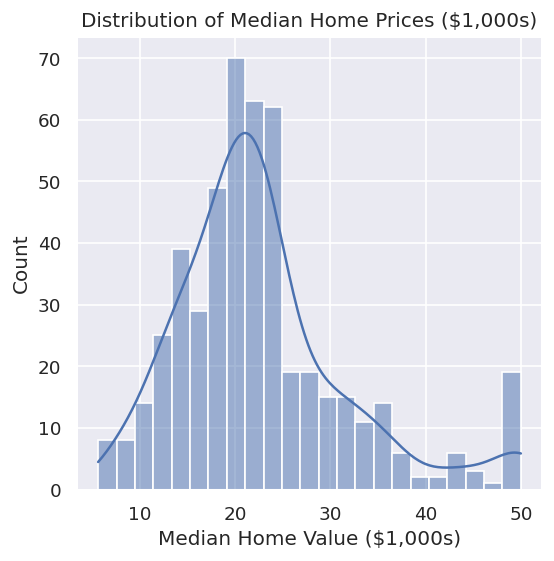

In [ ]:
#visualize the distribution of home value to check for skewed or unnormal data
plt.figure(figsize=(5, 5));
sns.histplot(x=df['MEDV'],
             kde=True);
plt.xlabel('Median Home Value ($1,000s)')
plt.title('Distribution of Median Home Prices ($1,000s)');

In [ ]:
#get summary statistics for homes by rivers vs. homes without rivers
df.groupby(['CHAS']).mean()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CHAS,,,,,,,,,,,,,
0,2.923363,11.810345,10.912371,0.549972,6.2758,67.476509,3.886722,9.349138,406.006466,18.501940,357.341810,12.592931,22.298491
1,1.851670,7.714286,12.719143,0.593426,6.5196,77.500000,3.029709,9.314286,386.257143,17.491429,372.997429,11.241714,28.440000


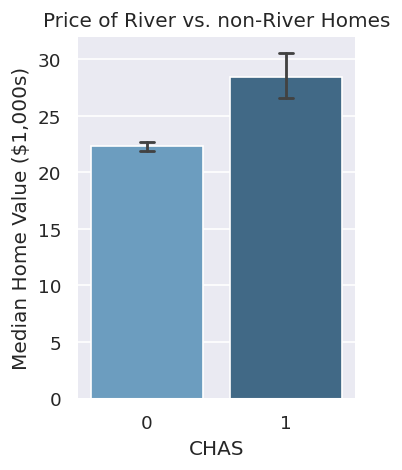

In [ ]:
#visualize the value of homes by rivers vs. homes without rivers
plt.figure(figsize=(3, 4));
sns.barplot(
    x='CHAS', 
    y='MEDV', 
    data=df, 
    ci=68, 
    color='#69b3a2',
    estimator=np.mean,
    capsize=.1,
    errwidth=1.7,
    palette="Blues_d",
    linewidth=1);
plt.title('Price of River vs. non-River Homes');
plt.ylabel('Median Home Value ($1,000s)');

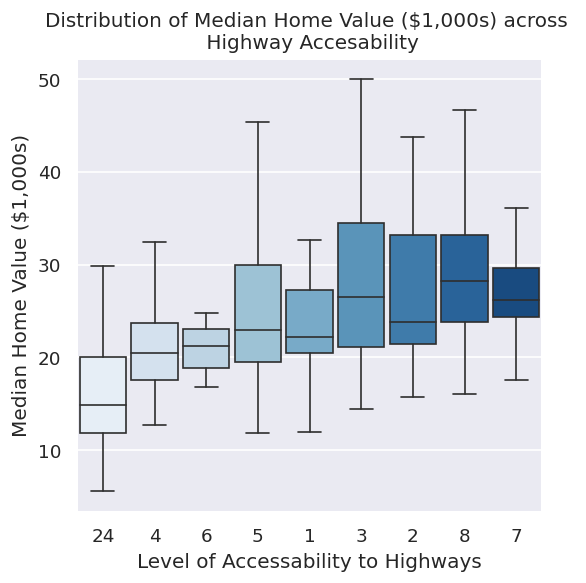

In [ ]:
#visualize the distribution of home value grouped by highway accessability rankings
plt.figure(figsize=(5, 5));
sns.boxplot(x='RAD',
            y='MEDV',
            data=df,
            palette='Blues',
            order=(24, 4, 6, 5, 1, 3, 2, 8, 7),
            linewidth=1,
            width=.9,
            showfliers=False);
plt.ylabel('Median Home Value ($1,000s)');
plt.xlabel('Level of Accessability to Highways');
plt.title('Distribution of Median Home Value ($1,000s) across \n Highway Accesability');

#Unsupervised Learning: Clustering

In [ ]:
#import libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#scale data for unsupervised learning performance
scaler = StandardScaler()
scaler.fit_transform(df)

#fit KMeans clusters to the data
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

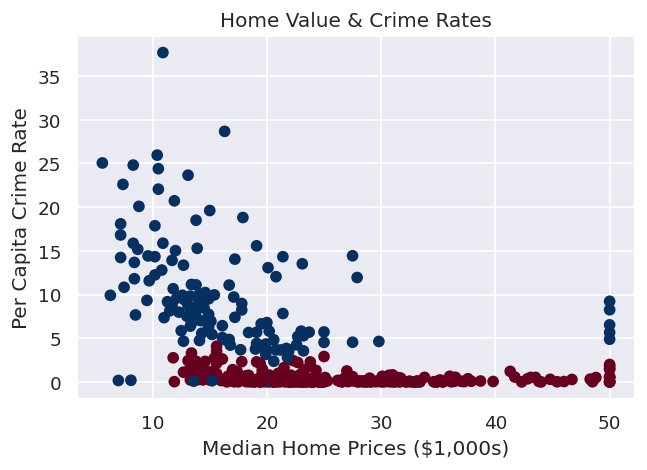

In [ ]:
#visualize clusters between home value and crime rates
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'],
            df['CRIM'],
            c = df['cluster'],
            cmap='RdBu')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Per Capita Crime Rate')
plt.title('Home Value & Crime Rates');

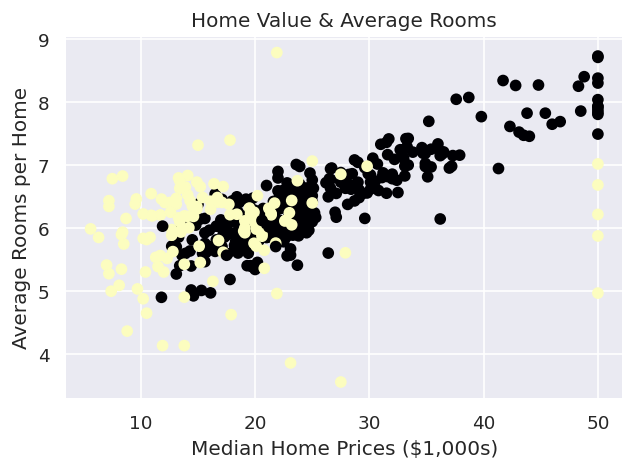

In [ ]:
#visualize clusters between price and rooms
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'],
            df['RM'],
            c = df['cluster'],
            cmap='magma')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Average Rooms per Home')
plt.title('Home Value & Average Rooms');

# Random Forest Regressor

In [ ]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV

#use train test splits to divide data into testing and training sets
X = df.drop(columns=['MEDV'])
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=.3)

In [ ]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

#create and fit default Random Forest model;
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
rf_predicted_df = rf_regressor.predict(X_test)

#score default Random Forest model
print('RMSE: ' + str(sqrt(mean_squared_error(rf_predicted_df, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(rf_regressor.score(X_test, y_test)))

RMSE: 2.998320059633394
---------------------------------
Testing Score: 0.8725232395854093


In [ ]:
#use GridSearchCV to find best hyperparameters for Random Forest
rf_estimator = RandomForestRegressor()

#create parameter grid for GridSearchCV
rf_params = {'n_estimators': range(50, 300, 50),
             'max_features': range(1, 30, 5),
             'max_depth': range(10, 200, 25),
             'min_samples_split': [2, 5, 10]}

#define GridSearchCV model
rf_grid_search = GridSearchCV(
    estimator=rf_estimator,
    param_grid=rf_params, 
    cv = 5,
    n_jobs = -1,
    verbose = True,
    scoring='neg_mean_squared_error')

#fit GridSearchCV model to the data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1972 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
#recieve optimal hyperparameters for Random Forest model
rf_grid_search.best_params_

{'max_depth': 185,
 'max_features': 11,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
#tune optimized Random Forest model
rf_regressor_opt = RandomForestRegressor(max_depth = 60,
                                         n_estimators = 150,
                                         min_samples_split = 2,
                                         max_features = 11,
                                         bootstrap = True)

#fit optimized Random Forest model
rf_regressor_opt.fit(X_train, y_train)

#score optimized Random Forest model
rf_predicted_opt = rf_regressor_opt.predict(X_test)
print('RMSE: ' + str(sqrt(mean_squared_error(rf_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(rf_regressor_opt.score(X_test, y_test)))

RMSE: 2.862022609844173
---------------------------------
Testing Score: 0.8838494800707212


# XGBoost Regression

In [ ]:
#import libraries
from xgboost import XGBRegressor

#create and fit default XGBoost model
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
XGB_predicted_df = XGB.predict(X_test)

#score default XGBoost model
print('RMSE: ' + str(sqrt(mean_squared_error(XGB_predicted_df, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(XGB.score(X_test, y_test)))

[06:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 2.899946987049883
---------------------------------
Testing Score: 0.8807508876272794


In [ ]:
#use GridSearchCV to find best hyperparameters for XGBoost
xgb_estimator = XGBRegressor()

#create parameter grid
xgb_params = {'learning_rate': [.001, .01, .1, .3, .5, .8],
          'max_depth': [1, 2, 3, 4, 5, 6],
          'max_features': [1, 2, 3, 4, 5, 6],
          'n_estimators': [20, 50, 80, 110, 140]}

#define GridSearchCV model
xgb_grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=xgb_params,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose=True)

#fit GridSearchCV model to the data
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3500 tasks      | elapsed:  1.4min


[06:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...a=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.8],
                         'max_depth': [1, 2, 3, 4, 5, 6],
 

In [ ]:
#recieve optimal hyperparameters for XGBoost modle
xgb_grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 6, 'max_features': 1, 'n_estimators': 50}

In [ ]:
#tune optimized XGBoost model
XGB_opt = XGBRegressor(learning_rate= 0.3,
                        max_depth = 6,
                        max_features = 1,
                        n_estimators = 50)

#fit optimized XGBoost modle
XGB_opt.fit(X_train, y_train)

#score optimized XGBoost model
XGB_predicted_opt = XGB_opt.predict(X_test)
print('RMSE: ' + str(sqrt(mean_squared_error(XGB_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(XGB_opt.score(X_test, y_test)))

[06:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 2.8323036882283392
---------------------------------
Testing Score: 0.8862491440563249


# KNeighborsRegressor

In [ ]:
#scale the data to increase the KNN model's performance
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#import libraries
from sklearn.neighbors import KNeighborsRegressor

#create and fit default KNN model
KNN = KNeighborsRegressor()
KNN.fit(X_train_sc, y_train)

#score default KNN model
KNN_predicted_df = KNN.predict(X_test_sc)
print('RMSE: ' + str(sqrt(mean_squared_error(KNN_predicted_df, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(KNN.score(X_test_sc, y_test)))

RMSE: 3.5847067755489657
---------------------------------
Testing Score: 0.8177857612709027


In [ ]:
#use GridSearchCV to find optimal hyperparameters
KNN_opt = KNeighborsRegressor()

#create parameter grid for 
KNN_params = {'n_neighbors': [5, 10, 20, 40, 80, 160, 250],
         'leaf_size': range(1,50,5),
         'weights': ['uniform','distance'],
         'leaf_size': [1,5,10,20,40]}

#define GridSearchCV model
KNN_grid_search = GridSearchCV(KNN_opt,
                               param_grid = KNN_params,
                               cv = 5,
                               verbose=True,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

#fit GridSearchCV to scaled data
KNN_grid_search.fit(X_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 40],
                         'n_neighbors': [5, 10, 20, 40, 80, 160, 250],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
#recieve optimal hyperparameters for KNN model
KNN_grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 5, 'weights': 'distance'}

In [ ]:
#tune optimized KNN model
KNN_opt = KNeighborsRegressor(leaf_size = 1,
                              n_neighbors = 5,
                              weights = 'distance')

#fit optimized KNN model to the data
KNN_opt.fit(X_train_sc, y_train)

#score optimized KNN model
KNN_predicted_opt = KNN_opt.predict(X_test_sc)
print('RMSE: ' + str(sqrt(mean_squared_error(KNN_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(KNN_opt.score(X_test_sc, y_test)))

RMSE: 3.257215854896151
---------------------------------
Testing Score: 0.8495583397022654


# Ensemble

In [ ]:
#import libraries
from sklearn.ensemble import VotingRegressor

#create and tune ensemble with all previous models
ensemble = VotingRegressor(estimators = [('rf', rf_regressor_opt),
                                          ('XGB', XGB_opt),
                                          ('KNN', KNN_opt)],
                                          weights=[10,15,1])
#fit ensemble model to the data
ensemble.fit(X_train, y_train)

#score ensemble model
ensemble_predicted = ensemble.predict(X_test)
print('RMSE: ' + str(sqrt(mean_squared_error(ensemble_predicted, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(ensemble.score(X_test, y_test)))

[06:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 2.7223403838696907
---------------------------------
Testing Score: 0.8949103637540816


# Comparing Model Performance

In [ ]:
#create dataframe for model performance comparison
model_performance_dict = {'Model': ['Random Forest',
                                    'XGBoost',
                                    'KNN',
                                    'Ensemble'],
                     'Accuracy Score': [rf_regressor_opt.score(X_test, y_test),
                                        XGB_opt.score(X_test, y_test),
                                        KNN_opt.score(X_test_sc, y_test),
                                        ensemble.score(X_test, y_test)],
                     'RMSE': [sqrt(mean_squared_error(rf_predicted_opt, y_test)),
                              sqrt(mean_squared_error(XGB_predicted_opt, y_test)),
                              sqrt(mean_squared_error(KNN_predicted_opt, y_test)),
                              sqrt(mean_squared_error(ensemble_predicted, y_test))]}

model_performance = pd.DataFrame(model_performance_dict)

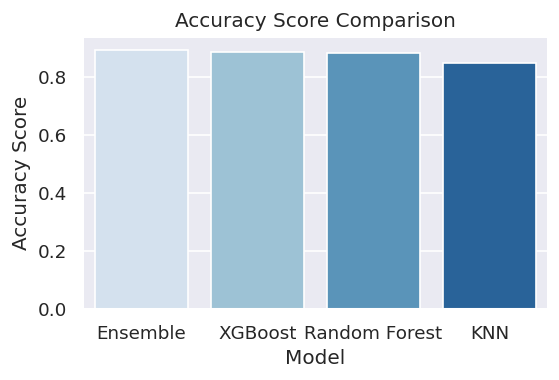

In [ ]:
#visualize model performances for accuracy score
plt.figure(figsize=(5, 3));
sns.barplot(data = model_performance,
            x = 'Model',
            y = 'Accuracy Score',
            palette='Blues',
            order=['Ensemble', 'XGBoost', 'Random Forest', 'KNN']);
plt.title('Accuracy Score Comparison');

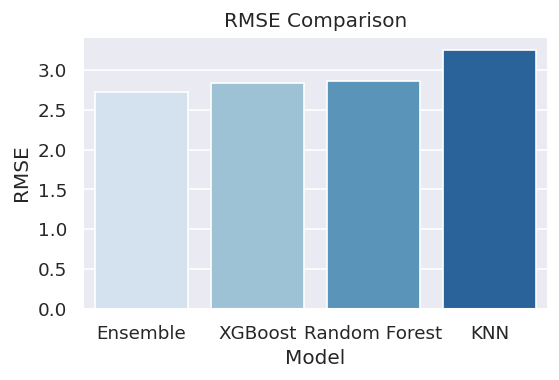

In [ ]:
#visualize model performances for RMSE
plt.figure(figsize=(5, 3));
sns.barplot(data = model_performance,
            x = 'Model',
            y = 'RMSE',
            palette='Blues',
            order=['Ensemble', 'XGBoost', 'Random Forest', 'KNN']);
plt.title('RMSE Comparison');

**The ensemble model has the highesst accuracy score and the lowest RMSE (error). We will use this model to generate our predictions on the testing set.**

In [ ]:

#use the ensemble model to create and save predictions
price_predictions = ensemble.predict(X_test)
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df.to_csv('price_predictions', index=False)